In [89]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

In [62]:
df = pandas.read_csv("../data/sources.extended.csv", index_col="source_id")
df = df.ix[~pandas.isnull(df.mutations)]
df.shape

(115, 43)

In [64]:
predicted = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors = [
    "treated",
    "timepoint",
    "metastasis",
    "specimen_interval",
    "tissue_type",
    "tumour_grade",
    "tumour_stage",
    "percentage_cellularity"
]

In [69]:
stan_y = df[predicted[0]]
stan_y

source_id
AOCS-001-1/SP101515      5937
AOCS-002-1/SP101517      1532
AOCS-004-1/SP101519      6786
AOCS-005-1/SP101521      5703
AOCS-034-13/SP101524    13626
AOCS-034-1/SP101523      6913
AOCS-055-1/SP101526     15112
AOCS-056-1/SP101528      7102
AOCS-057-1/SP101530      6201
AOCS-058-1/SP101532      9199
AOCS-059-1/SP101536      3779
AOCS-060-1/SP101540      4540
AOCS-061-1/SP101544      6197
AOCS-063-1/SP101548      6644
AOCS-064-13/SP101554    23773
AOCS-064-1/SP101552     16841
AOCS-065-13/SP101560     7423
AOCS-065-1/SP101558      6031
AOCS-075-1/SP101564      4953
AOCS-076-1/SP101568      6281
AOCS-077-1/SP101572      3084
AOCS-078-1/SP101576      9022
AOCS-079-1/SP101580      6984
AOCS-080-1/SP101584      7007
AOCS-081-1/SP101588      6770
AOCS-083-1/SP101592      6604
AOCS-084-1/SP101596      5110
AOCS-085-1/SP101600      2167
AOCS-086-1/SP101604      6321
AOCS-086-13/SP101606    14497
                        ...  
AOCS-144-1/SP101951      5735
AOCS-145-1/SP101961     10100


In [66]:
stan_donor = df.donor.astype('category')
stan_donor.values.codes

array([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13, 14,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25, 26, 26, 27, 28,
       28, 29, 29, 30, 30, 30, 31, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 61, 62, 62, 63, 64, 64, 64, 64, 65, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 88, 88, 89, 90, 91, 91, 92, 92], dtype=int8)

In [67]:
stan_donor.nunique()

93

In [68]:
stan_x = df[predictors].copy()
stan_x["tumour_stage"] = stan_x.tumour_stage.map({"IV": 4, "III": 3, "II": 2, "I": 1})
stan_x["recurrence"] = stan_x["timepoint"] == "recurrence"
del stan_x["timepoint"]
stan_x["ascites"] = stan_x["tissue_type"] == "ascites"
del stan_x["tissue_type"]
stan_x.fillna(stan_x.mean(0), inplace=True)  # mean fill NA values
stan_x = stan_x.astype(float)
print(stan_x.shape)
stan_x

(115, 8)


,treated,metastasis,specimen_interval,tumour_grade,tumour_stage,percentage_cellularity,recurrence,ascites
source_id,,,,,,,,
AOCS-001-1/SP101515,0,0,0,3.000000,3.000000,73.000000,0,0
AOCS-002-1/SP101517,0,0,0,2.000000,3.000000,85.000000,0,0
AOCS-004-1/SP101519,0,0,0,3.000000,3.000000,77.000000,0,0
AOCS-005-1/SP101521,0,0,0,3.000000,3.000000,90.000000,0,0
AOCS-034-13/SP101524,1,0,1597,2.814815,3.148148,99.000000,1,1
AOCS-034-1/SP101523,0,0,0,3.000000,3.000000,84.000000,0,0
AOCS-055-1/SP101526,0,0,0,3.000000,3.000000,82.000000,0,0
AOCS-056-1/SP101528,0,0,0,2.000000,3.000000,94.000000,0,0
AOCS-057-1/SP101530,0,0,0,3.000000,3.000000,68.000000,0,0


In [53]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [108]:
# stan model
model1 = """
data {
    // Hyper priors
    real global_mean_prior_mean;
    real global_mean_prior_std;
    real predictor_coefficients_std;
    real donor_sigma_max;
    real sample_sigma_max;

    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_predictors;
    int<lower=0> num_donors;

    // Data
    vector[num_predictors] predictors[num_sources];
    int<lower=0> donors[num_sources];
    real<lower=0> y[num_sources];  // predicted variable
}
parameters {
    real global_mean;
    real donor_sigma;
    real sample_sigma;
    vector[num_donors] donor_mean;    
    vector[num_predictors] predictor_coefficients;
}
transformed parameters {
    real lp;
    real mu[num_sources];
    
    for (i in 1:num_sources) {
        lp <- dot_product(predictors[i], predictor_coefficients);
        mu[i] <- donor_mean[donors[i]] * exp(lp);
    }
}
model {
    global_mean ~ normal(global_mean_prior_mean, global_mean_prior_std);
    donor_mean ~ normal(global_mean, donor_sigma);
    donor_sigma ~ uniform(500, donor_sigma_max);
    sample_sigma ~ uniform(0.001, sample_sigma_max);
    predictor_coefficients ~ normal(0, predictor_coefficients_std);
    y ~ normal(mu, sample_sigma);    
}
""".strip()

def line(num):
    return model1.split("\n")[num - 2]



data = {
    'global_mean_prior_mean': 10000,
    'global_mean_prior_std': 5000,
    'predictor_coefficients_std': 1,
    'donor_sigma_max': 5000,
    'sample_sigma_max': 5000,
    
    'num_sources': len(stan_x.index),
    'num_predictors': len(stan_x.columns),
    'num_donors': stan_donor.nunique(),
        
    'predictors': stan_x.values.astype(float),
    'donors': stan_donor.values.codes + 1,  # convert to 1-indexed
    'y': stan_y.values,
}
def init(data):
    return {
        'global_mean': data['global_mean_prior_mean'],
        'donor_sigma': 500 + data['donor_sigma_max'] / 4,
        'sample_sigma': data['sample_sigma_max'] / 4,
        'donor_mean': numpy.ones(data['num_donors']) * data['global_mean_prior_mean'],
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

print("")
print("*" * 40)
print("DATA")
print_dict(data)
print("")

print("*" * 40)
print("INITIAL VALUES")
print_dict(init(data))

sys.stdout.flush()
chains = 1
fit = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=5000, chains=chains)
print("DONE")


  1 data {
  2     // Hyper priors
  3     real global_mean_prior_mean;
  4     real global_mean_prior_std;
  5     real predictor_coefficients_std;
  6     real donor_sigma_max;
  7     real sample_sigma_max;
  8 
  9     // Data sizes
 10     int<lower=0> num_sources;
 11     int<lower=0> num_predictors;
 12     int<lower=0> num_donors;
 13 
 14     // Data
 15     vector[num_predictors] predictors[num_sources];
 16     int<lower=0> donors[num_sources];
 17     real<lower=0> y[num_sources];  // predicted variable
 18 }
 19 parameters {
 20     real global_mean;
 21     real donor_sigma;
 22     real sample_sigma;
 23     vector[num_donors] donor_mean;    
 24     vector[num_predictors] predictor_coefficients;
 25 }
 26 transformed parameters {
 27     real lp;
 28     real mu[num_sources];
 29     
 30     for (i in 1:num_sources) {
 31         lp <- dot_product(predictors[i], predictor_coefficients);
 32         mu[i] <- donor_mean[donors[i]] * exp(lp);
 33     }
 34 }
 35 model {
 

In [109]:
extracted = fit.extract()
fit

Inference for Stan model: anon_model_52ce5b8803ec29544d44aee91d77a36b.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
global_mean                1.0e4   14.04  24.32  1.0e4  1.0e4  1.0e4  1.0e4  1.0e4    3.0   2.52
donor_sigma               506.36    0.63   7.23 500.12 501.77 504.14 508.33 526.72  132.0    1.0
sample_sigma              4673.5   93.82 229.82 4258.8 4504.9 4671.7 4920.3 4991.5    6.0   1.21
donor_mean[0]             9933.0   11.53  36.47 9857.3 9915.9 9935.6 9957.9 9996.2   10.0   1.01
donor_mean[1]              1.0e4    8.01  24.03 9992.0  1.0e4  1.0e4  1.0e4  1.0e4    9.0   1.06
donor_mean[2]             9919.5    3.11   9.83 9898.0 9912.9 9919.4 9925.9 9943.1   10.0   1.05
donor_mean[3]             9984.0    3.65   6.32 9976.4 9978.6 9981.2 9990.7 9995.4    3.0   2.41
donor_mean[4]              1.1e4   

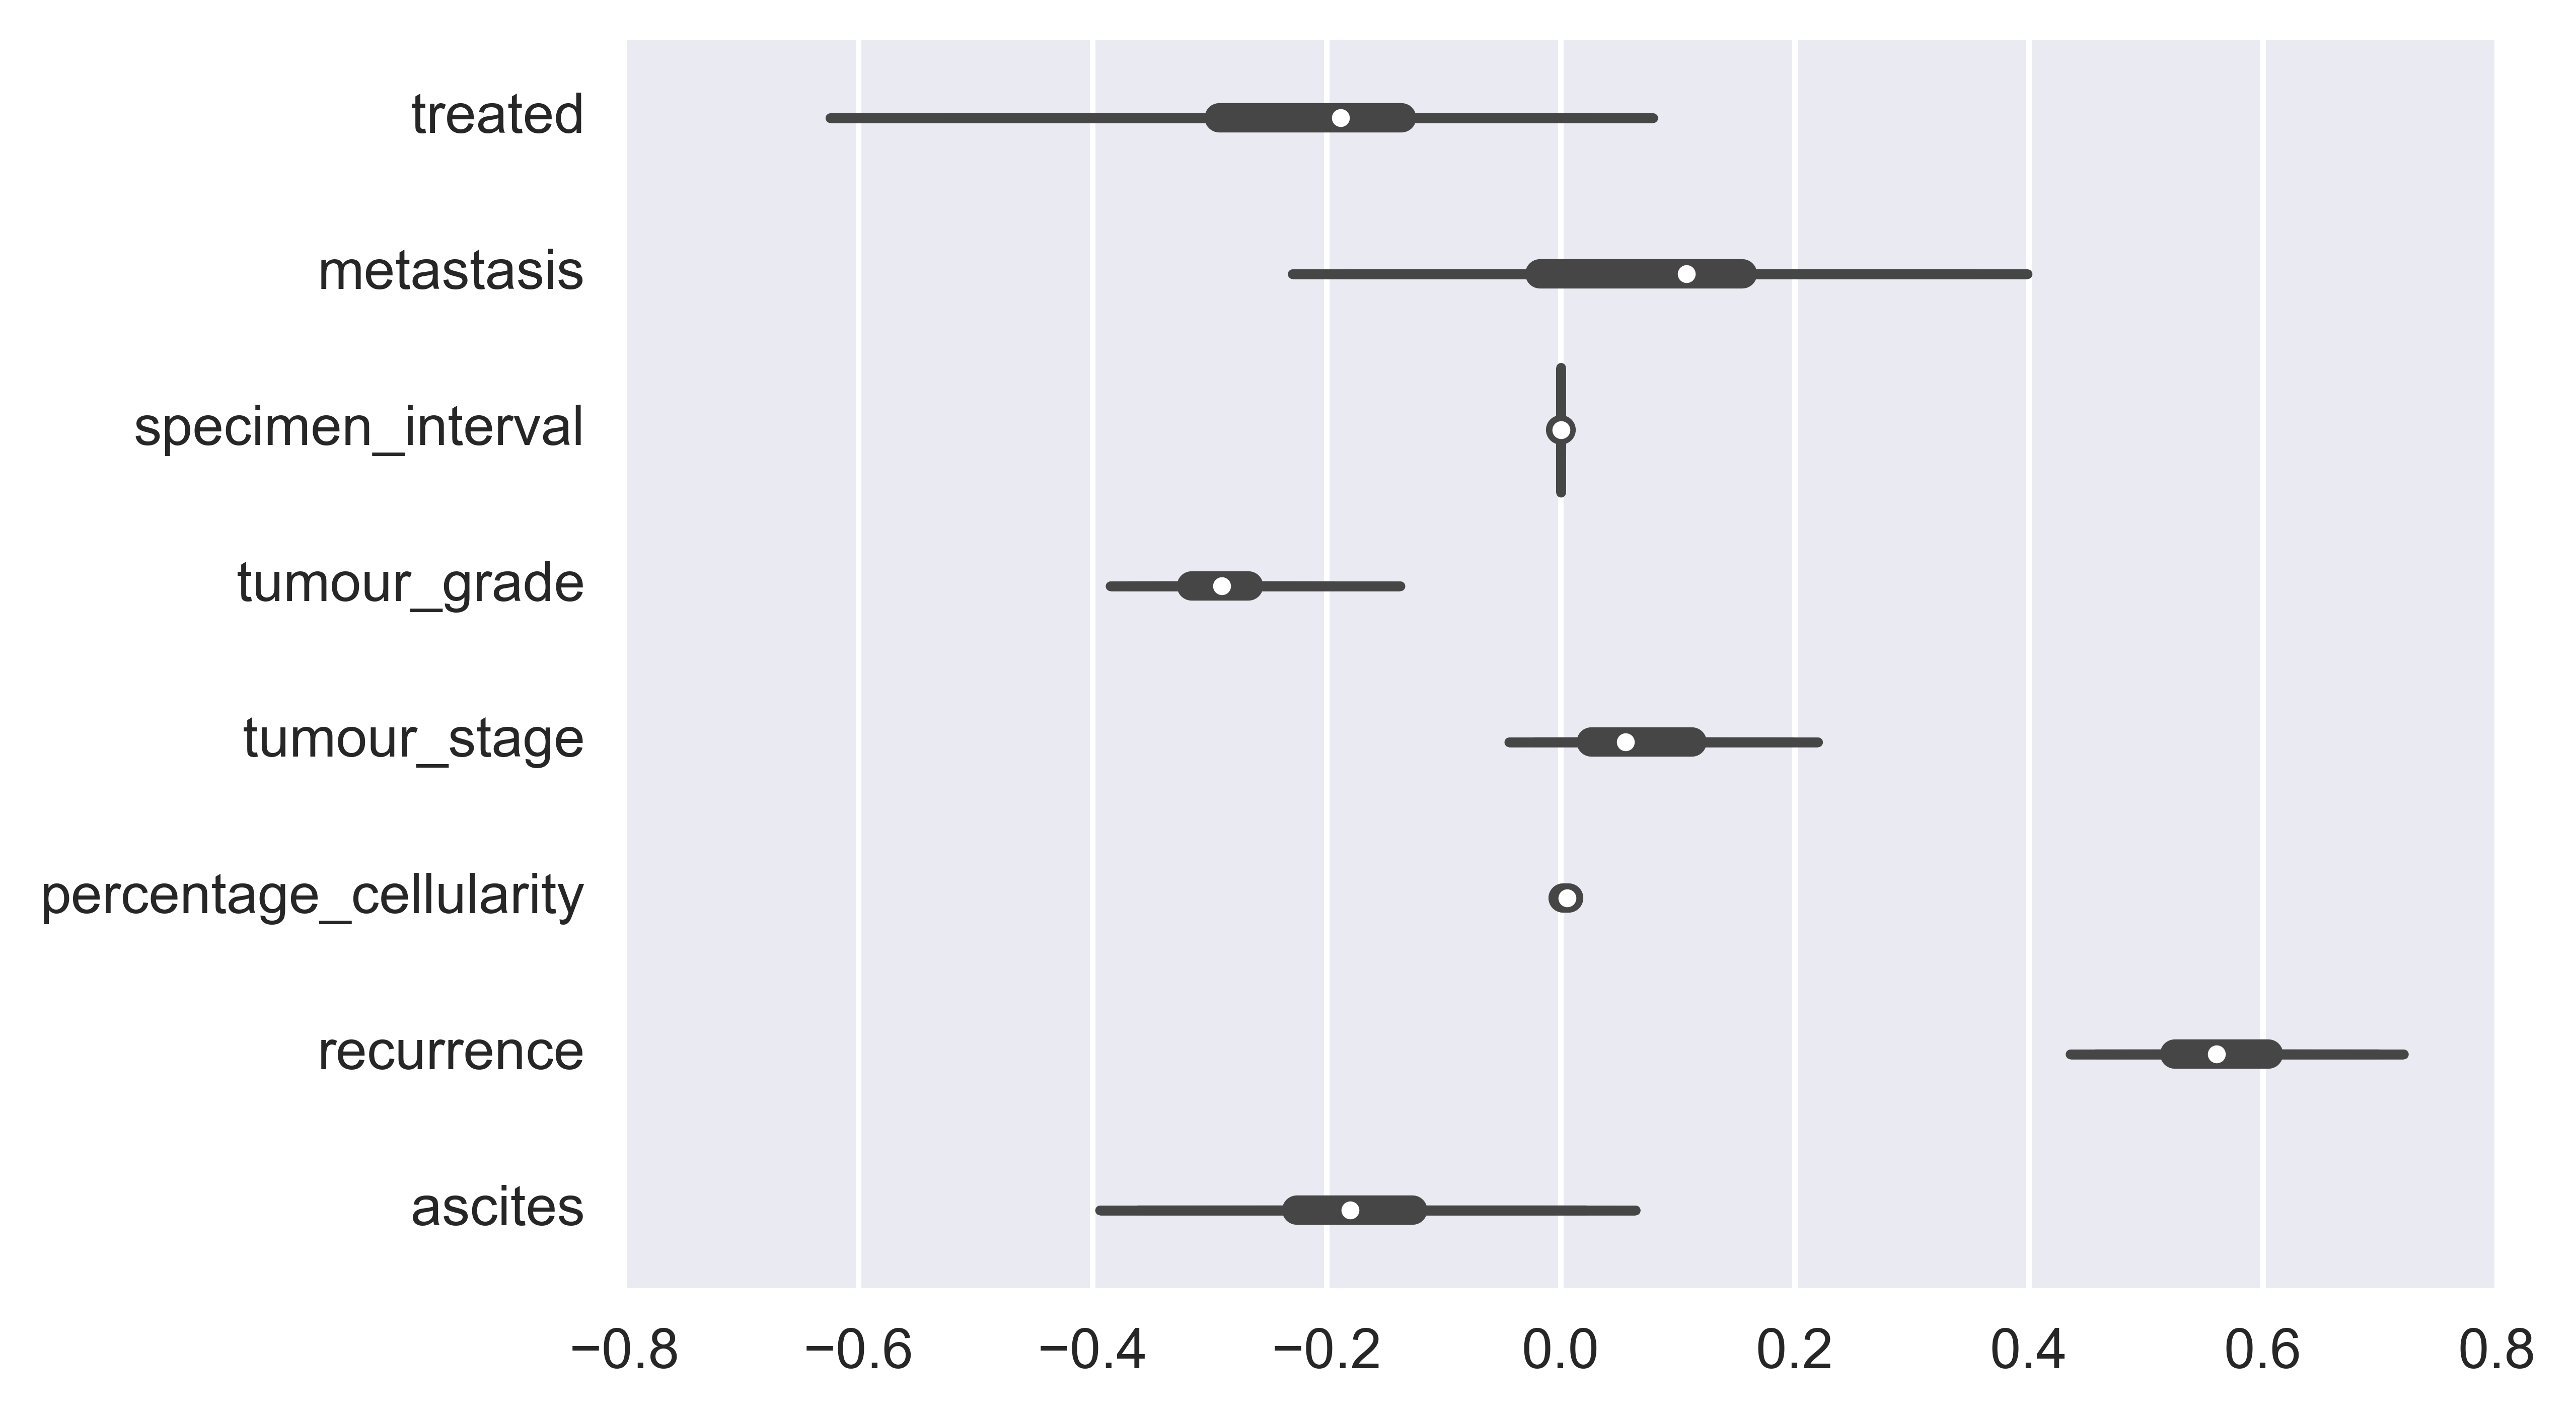

In [110]:
fit_coefficients = pandas.DataFrame(extracted['predictor_coefficients'],
                           columns=stan_x.columns)
fit_coefficients

seaborn.violinplot(fit_coefficients, orient="h")

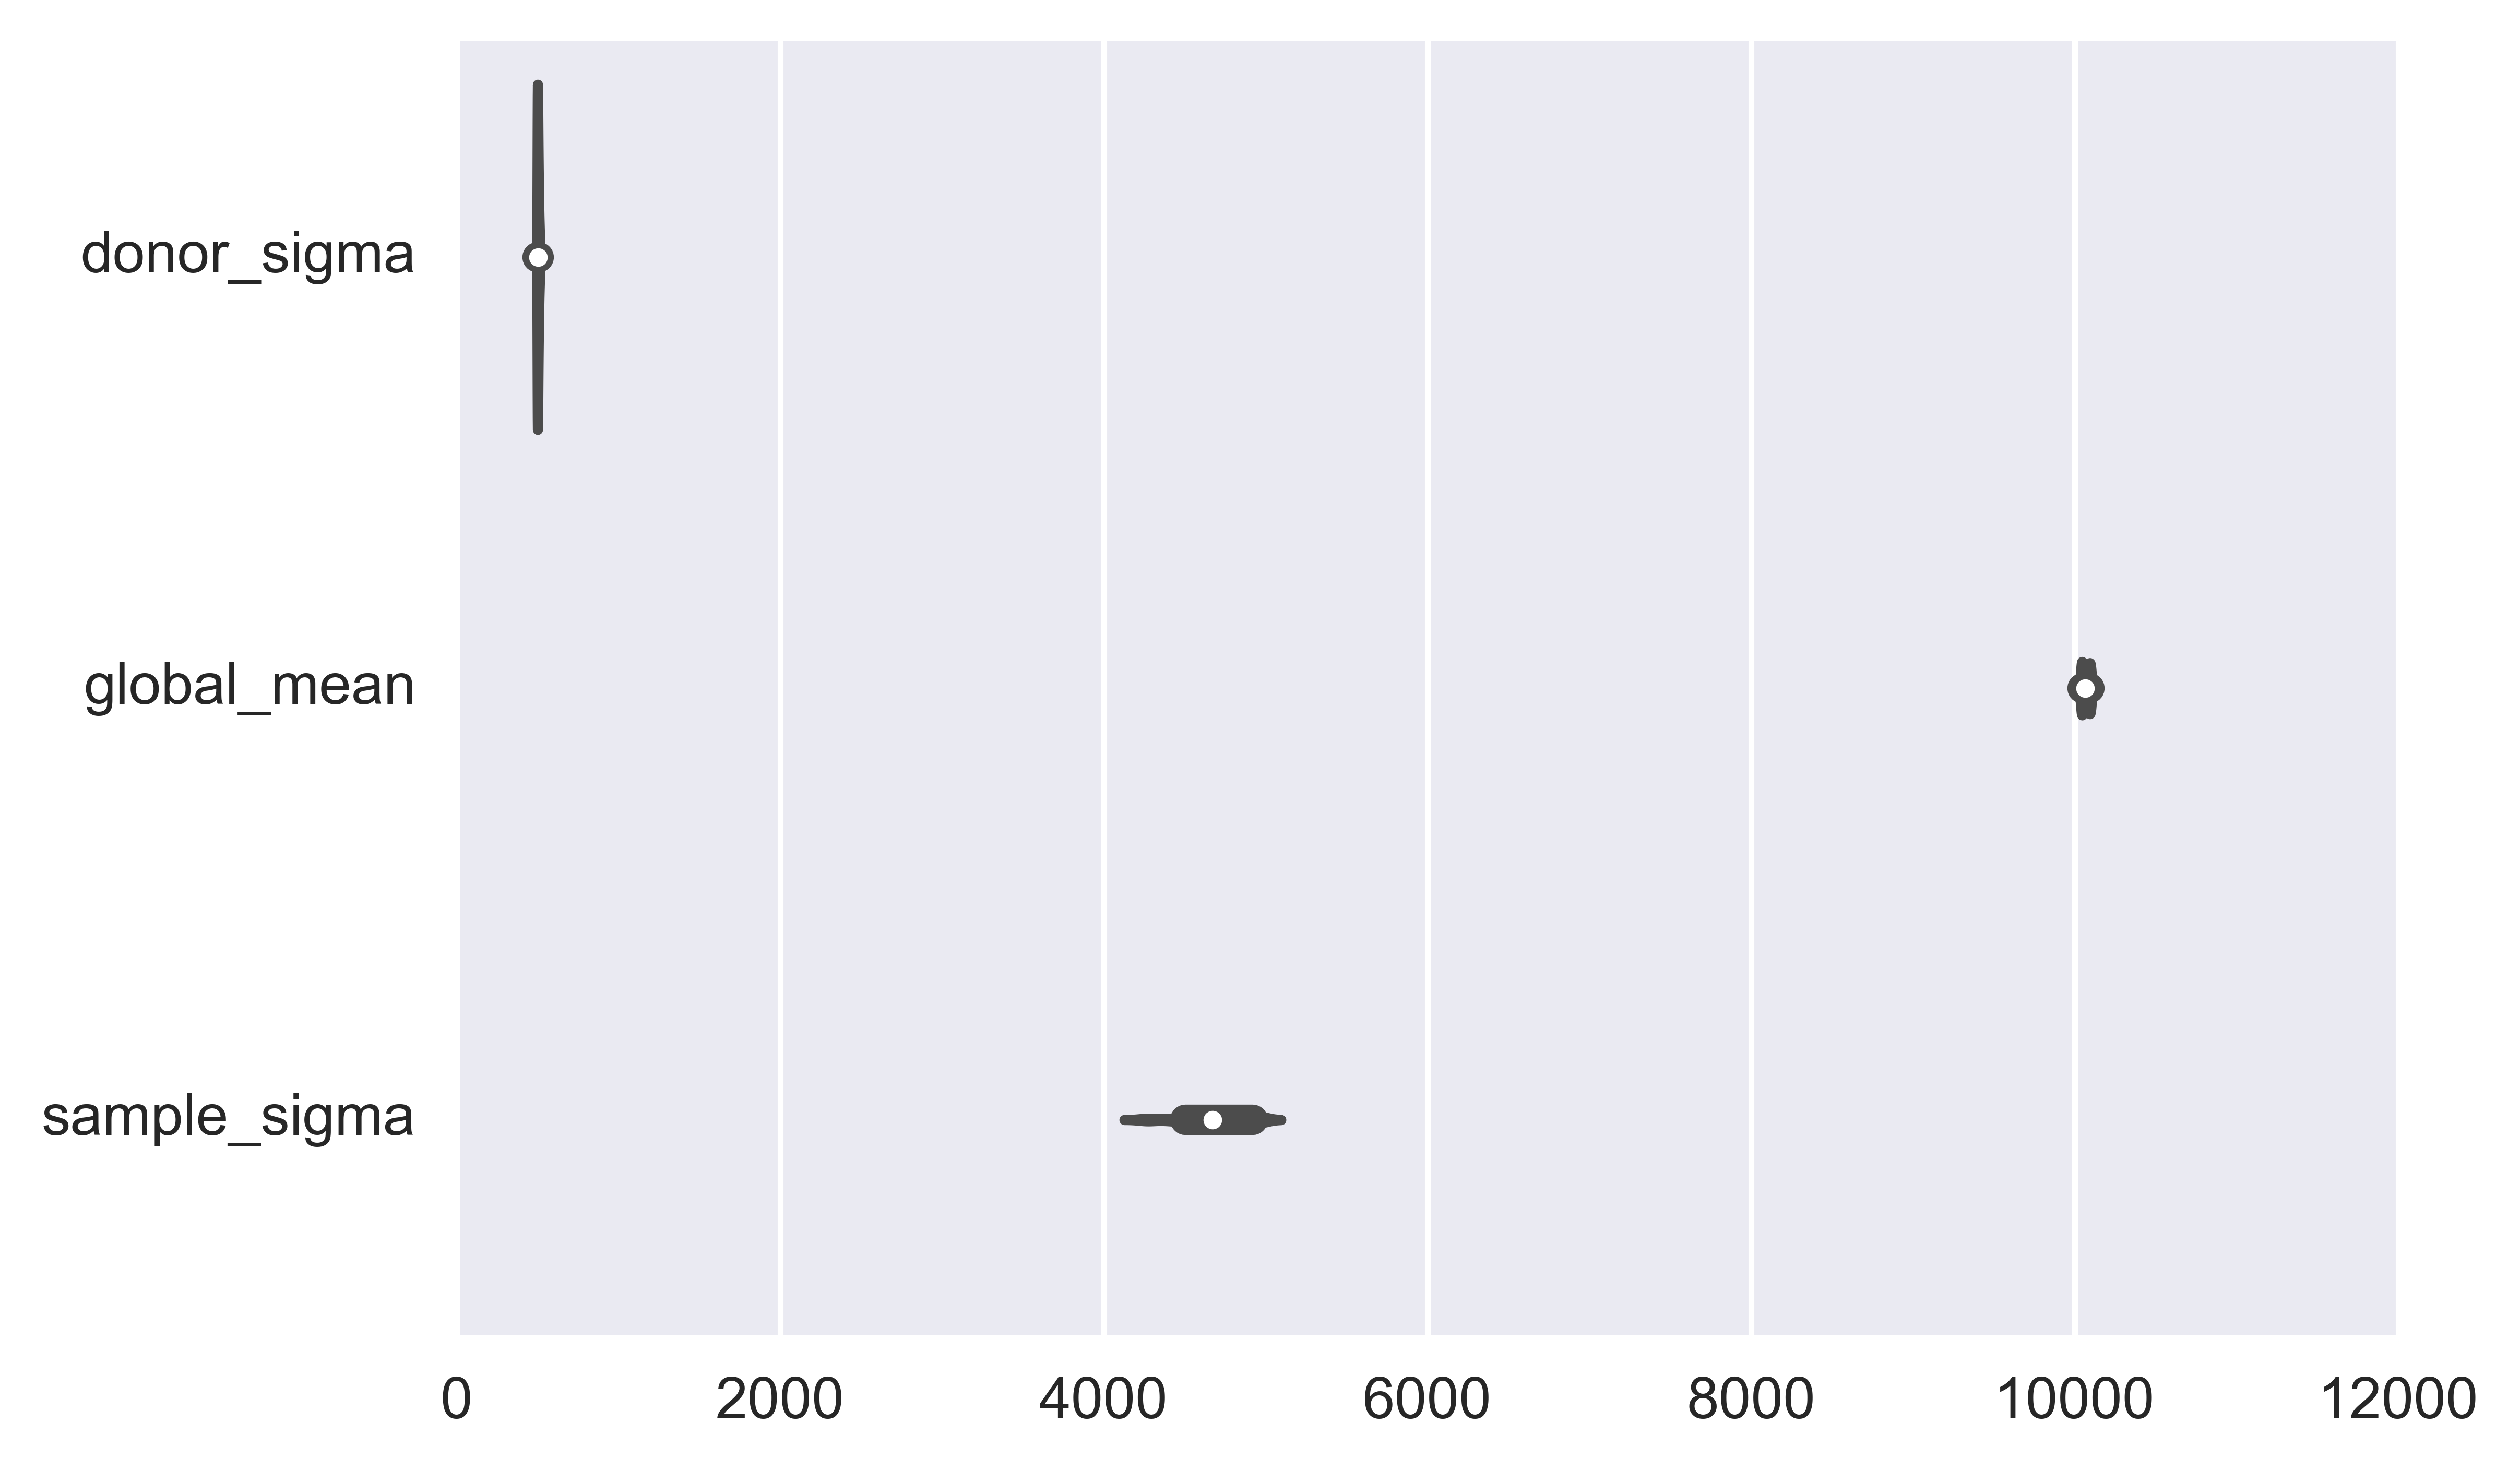

In [111]:
fit_scalars = pandas.DataFrame(
    dict((field, extracted[field])
         for field in ["global_mean", "donor_sigma", "sample_sigma"]))
seaborn.violinplot(fit_scalars, orient="h")

In [112]:
fit_donor_means = pandas.DataFrame(extracted['donor_mean'],
                           columns=stan_donor.values.categories)
fit_donor_means
pyplot.figure(figsize=(30,10))
seaborn.violinplot(fit_donor_means, orient="h")